# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn

#merge dataframes and keep only matching records based on offer_id, df_combined
df_combined = df_transactions.merge(df_offers, how='inner', on='offer_id')

#pivot to create dataframe indexed by customer with boolean columns for offer response, df_pivot
df_pivot = pd.pivot_table(df_combined, values='n', columns=['offer_id'], index='customer_name', fill_value=0, aggfunc=sum)

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [5]:
# your turn

Lower values of SS should indicate better clusterings. As sum-of-squares decrease, the individual point differences in distance betwen x<sub>i</sub> and mu<sub>k</sub>, each point and the cluster mean, respectively, shrink. That implies that the density of points within the cluster is higher than a sparse cluster with a higher sum-of-squares.

Text(0, 0.5, 'sum of squares, inertia')

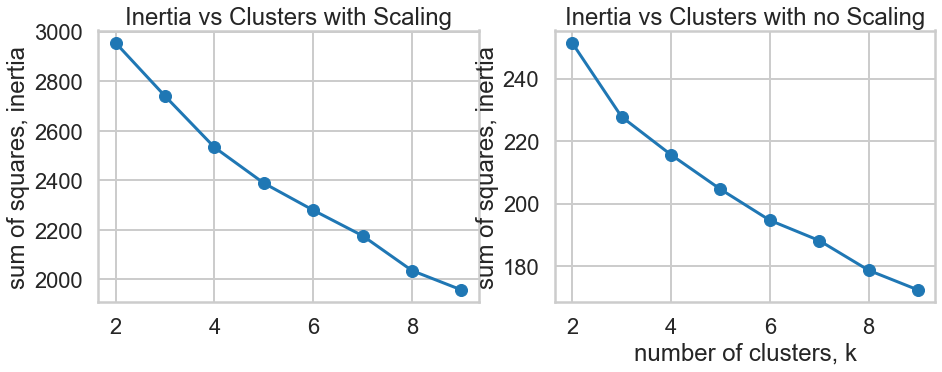

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#create numpy array for dataframe columns representing offers
x_cols = df_pivot.to_numpy(copy=True)

#instantiate empty list for storing sum-of-squares values, inertias
inertias_s = []

#designate the range of clusters to test through
ks = range(2,10)

for k in ks:
    scaler = StandardScaler()
    model = KMeans(n_clusters=k, random_state=15)
    pipeline = make_pipeline(scaler, model)
    pipeline.fit(x_cols)
    pipeline.predict(x_cols)
    inertias_s.append(pipeline[1].inertia_)
    
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(ks, inertias_s, '-o')
plt.title('Inertia vs Clusters with Scaling')
plt.ylabel('sum of squares, inertia')

inertias_ns = []
for k in ks:
    model = KMeans(n_clusters=k, random_state=15)
    model.fit(x_cols)
    model.predict(x_cols)
    inertias_ns.append(model.inertia_)
plt.subplot(1,2,2)    
plt.plot(ks, inertias_ns, '-o')
plt.title('Inertia vs Clusters with no Scaling')
plt.xlabel('number of clusters, k')
plt.ylabel('sum of squares, inertia')

Given this elbow curve, I would start with a k of 4. It becomes a fairly linear and incremental relationship when gauging the gain of additional clusters vs the inertia.

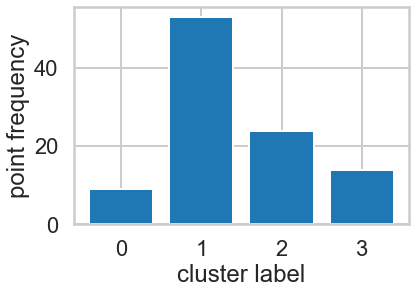

In [7]:
#barchart with the number of points per cluster given k=4

import numpy as np

#scale, fit, and predict labels
scaler = StandardScaler()
model = KMeans(n_clusters=4, random_state=15)
pipeline = make_pipeline(scaler, model)
pipeline.fit(x_cols)
labels = pipeline.predict(x_cols)

#plot labels and count of predictions per each label
keys, counts = np.unique(labels, return_counts=True)
plt.bar(keys, counts)
plt.xlabel('cluster label')
plt.ylabel('point frequency')
plt.show()

-----

Challenges with elbow method:
* The inertia vs k plot did not have a sharply-defined "elbow" or sharp decline in sum of squares values. Picking a K value seemed less clear than in prior examples. I am wondering if there is a percent decrease threshold in SS that is commonly accepted / adopted or similar tribal knowledge among data scientists
* The inertia vs k plot for the scaled run was even less helpful as the differences in ESS were less pronounced


### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.08202796200037837
For n_clusters = 3 The average silhouette_score is : 0.0955977011914056
For n_clusters = 4 The average silhouette_score is : 0.1207136129359761
For n_clusters = 5 The average silhouette_score is : 0.12901751351571336
For n_clusters = 6 The average silhouette_score is : 0.12939112334294217
For n_clusters = 7 The average silhouette_score is : 0.1419885829624855
For n_clusters = 8 The average silhouette_score is : 0.13882050458868686
For n_clusters = 9 The average silhouette_score is : 0.11214090795512482


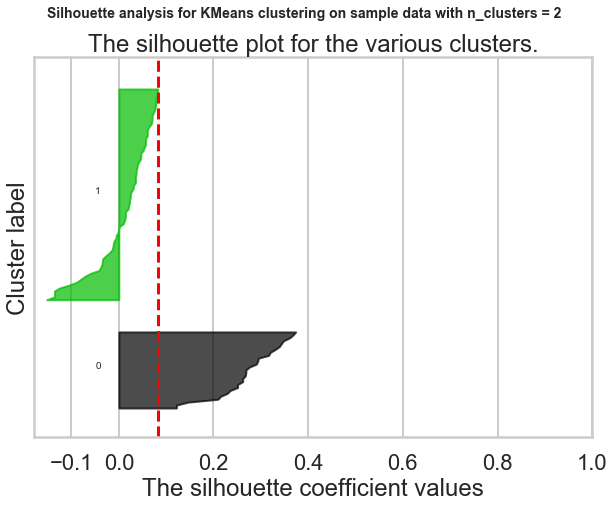

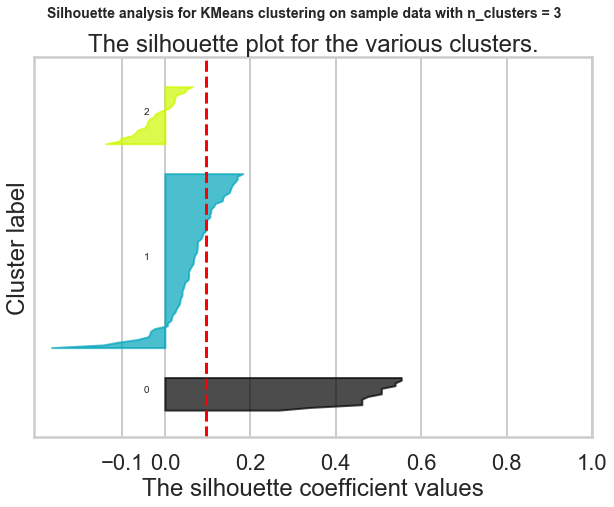

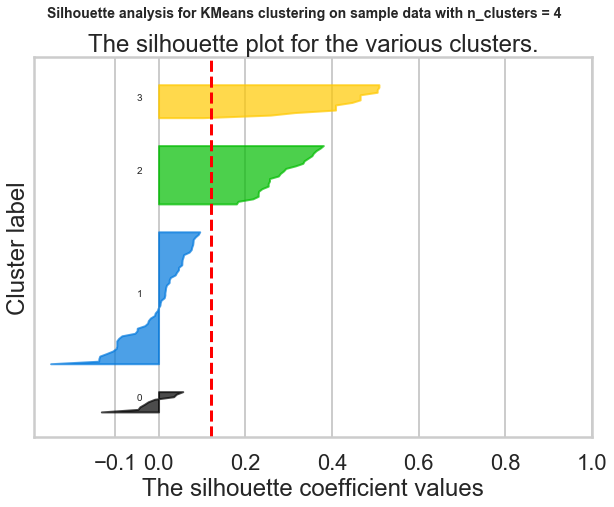

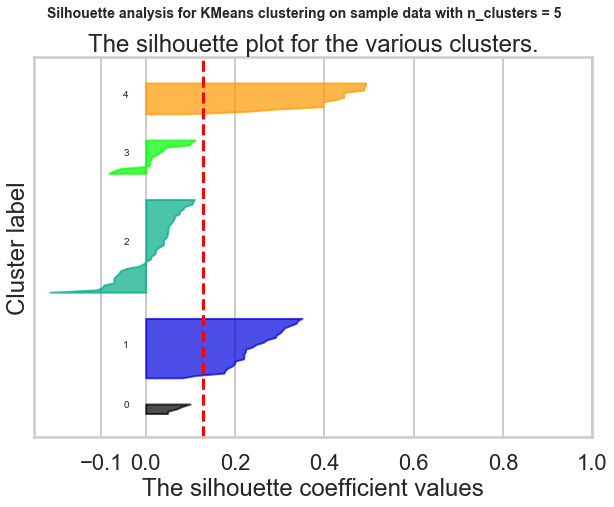

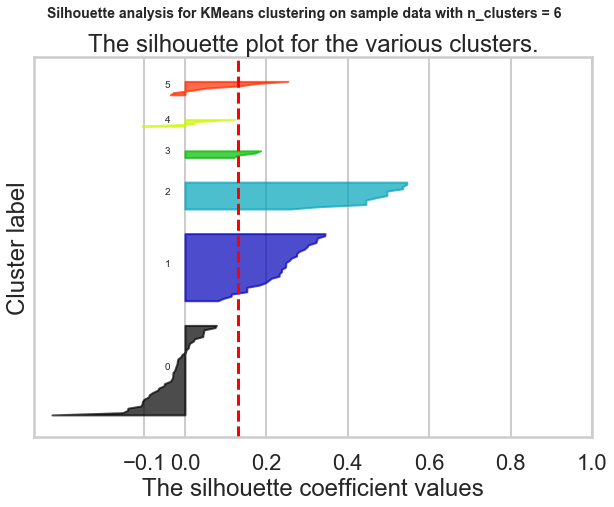

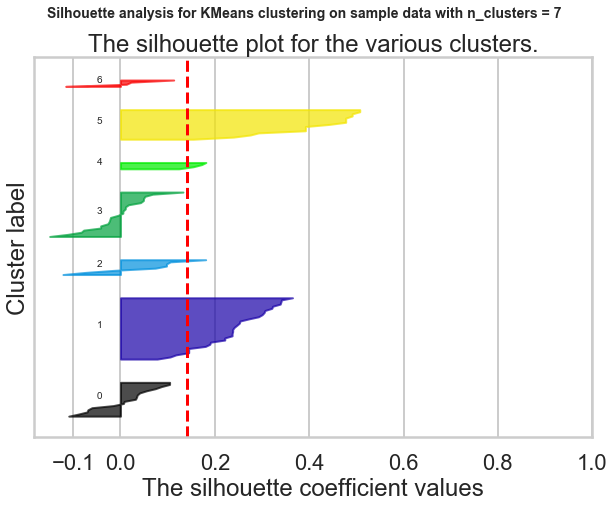

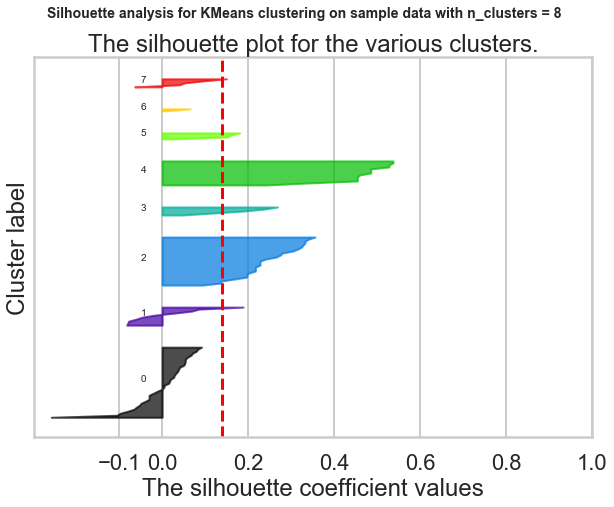

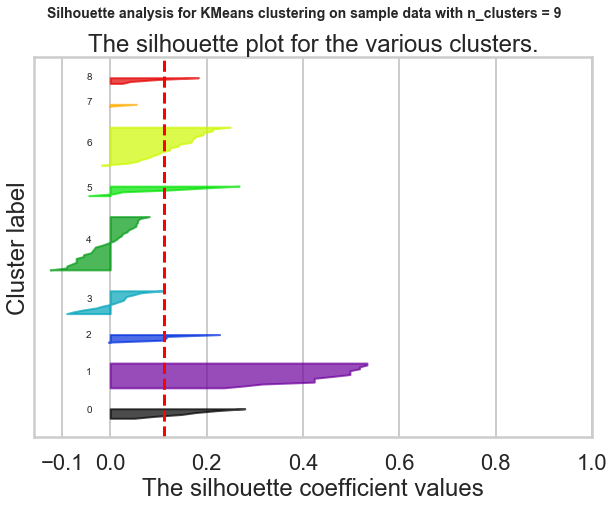

In [8]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm



#set k range to loop over
ks = range(2,10)

#store k and labels for later use
cluster_label_list = []

#plot silhouette_sample results for each k value option
for n_clusters in ks:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value
    scaler = StandardScaler()
    kmeans = KMeans(n_clusters=n_clusters, random_state=15)
    pipeline = make_pipeline(scaler, kmeans)
    pipeline.fit(x_cols)
    cluster_labels = pipeline.predict(x_cols)
    cluster_label_list.append((list(cluster_labels)))
    
    #compute silhouette average per cluster
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Text(0.5, 1.0, 'silhouette scores by feature')

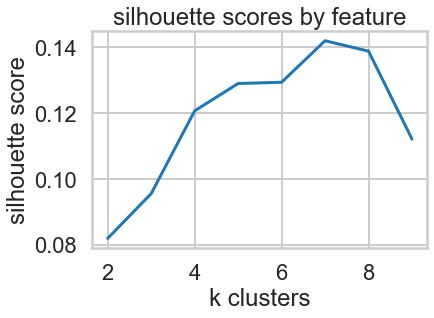

In [9]:
#instantiate list to hold scores
sil_scores = []

#loop through ks and compute silhouette scores
for k in ks:
    scaler = StandardScaler()
    model = KMeans(n_clusters=k, random_state=15)
    pipeline = make_pipeline(scaler, model)
    pipeline.fit(x_cols)
    labels = pipeline.predict(x_cols)
    sil_score = silhouette_score(x_cols, labels)
    sil_scores.append(sil_score)
    
plt.plot(np.arange(2,10), sil_scores)
plt.xlabel('k clusters')
plt.ylabel('silhouette score')
plt.title('silhouette scores by feature')

By these silhouette score findings, the best option for k is 7 but the score is still quite weak. This differs from the elbow method quite severely. Perhaps this data is struggling with data that is not as "blob-like" as some others and are close to, if not currently, overlapping to some degree.

-----


### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

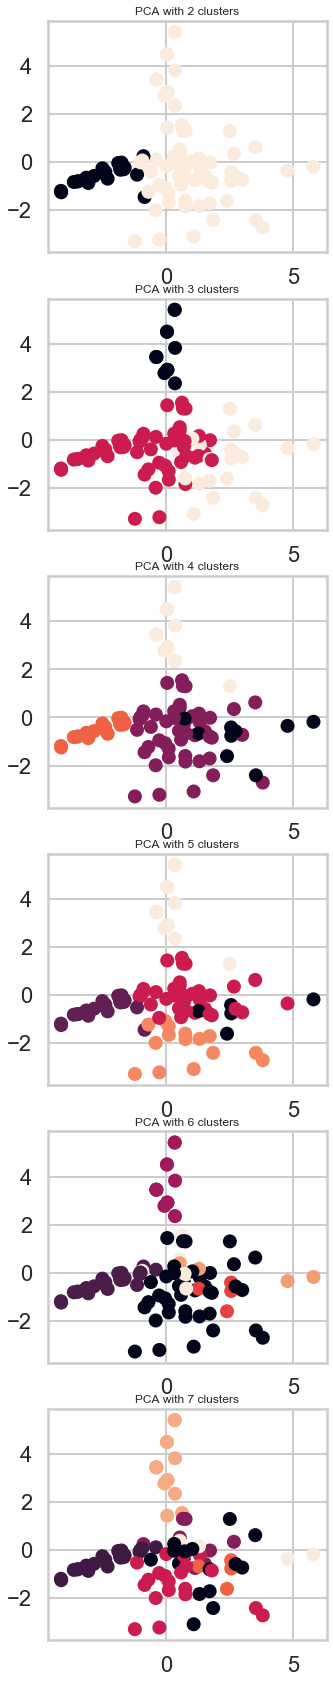

In [10]:
#your turn
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA(n_components=2, random_state=15)
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x_cols)
transformed = pipeline.transform(x_cols)

#build dataframe for plotting
pca_df = pd.DataFrame({
    'customer_name': df_pivot.index,
    'x': transformed[:, 0],
    'y': transformed[:, 1],
    'k2': cluster_label_list[0],
    'k3': cluster_label_list[1],
    'k4': cluster_label_list[2],
    'k5': cluster_label_list[3],
    'k6': cluster_label_list[4],
    'k7': cluster_label_list[5],
    'k8': cluster_label_list[6]
})

#plot subplots for PCA and two to 8 components
plt.figure(figsize=(5, 40))
for i, j in enumerate(range(2, 8)):
    plt.subplot(8, 1, i + 1)
    plt.title('PCA with ' + str(j) + ' clusters', fontsize=12)
    plt.scatter(x=pca_df['x'], y=pca_df['y'], c=pca_df[('k' + str(j))])

---

Based on these clusterings while visualizing the principal components, k of 3 seems to be the most visually pleasing clustering. Four is close, but it seems recruit points from the class on the left and the right while likely lowering classification scores. This finding is corroborated most by both the silhouette scores and the sum-of-squares approach in retrospect. In the sum of squares plot, the slope does change there sharply for the unscaled plot. In the silhouette, that clustering seems to have three clusters that do fairly well but in four, label 1 has quite a few poor scoring data points.

---

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

Text(0, 0.5, 'Variance Explained')

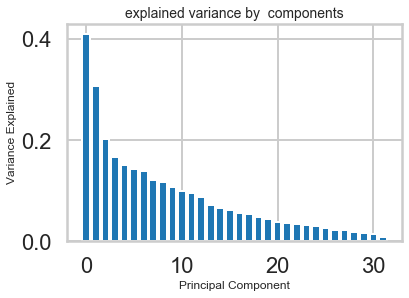

In [11]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)


# pca.components and variance
plt.bar(np.arange(len(pca.components_)), pca.explained_variance_)
plt.title('explained variance by  components', fontsize=14)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Variance Explained', fontsize=12)



---

Looking at explained variance by component, the number of components seems to sit right around 3. Explained variance changes more incrementally after that point

---

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


##### Affinity Propogation

-----

In [12]:
#store the scaled dataset in its transformed form, x_scld
scaler = StandardScaler()
scaler.fit(x_cols)
x_scld = scaler.transform(x_cols)

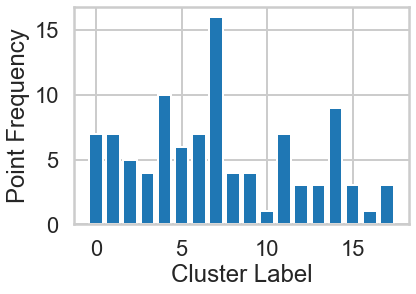

The silhouette average for this classifier: 0.116


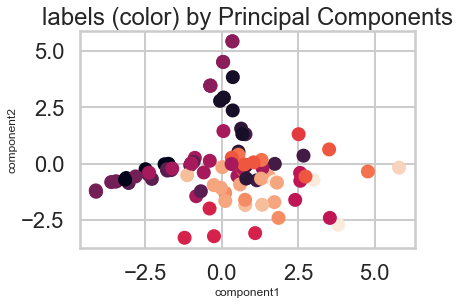

In [13]:
#affinity Propagation with no parameter tuning
from sklearn.cluster import AffinityPropagation

scaler = StandardScaler()
afp = AffinityPropagation()
afp.fit(x_scld)
labels = afp.predict(x_scld)

#visualize
keys, counts = np.unique(labels, return_counts=True)
plt.bar(keys, counts)
plt.xlabel('Cluster Label')
plt.ylabel('Point Frequency')
plt.show()

#plot 2 principal components and labels classified here
plt.scatter(x=pca_df['x'], y=pca_df['y'], c=labels)
plt.xlabel('component1', fontsize=12)
plt.ylabel('component2', fontsize=12)
plt.title('labels (color) by Principal Components')

#compute silhouette_average for this model
silhouette_avg = silhouette_score(x_cols, labels)
print('The silhouette average for this classifier:', round(silhouette_avg,3))


silhouette_score:  0.1353386008012102 parameters: 0.7244448979591837|950
Wall time: 18.9 s


Text(0.5, 1.0, 'labels (color) by Principal Components')

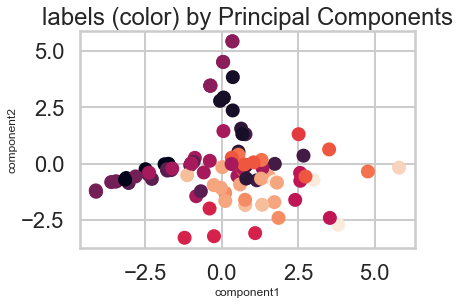

In [42]:
%%time
#affinity propagation with tuning
param_space = {
    'damping': list(np.linspace(0.5, 0.9999, 50)),
    'max_iter' : list(np.arange(50, 1000, 50))}

storage_d = {}
for i in param_space['damping']:
    for iterations in param_space['max_iter']:
            try:
                afp = AffinityPropagation(damping=i, max_iter=int(iterations), convergence_iter=15)
                labels = afp.fit_predict(x_scld)
                score = silhouette_score(x_scld, labels)
                storage_d[score] = str(i) + '|' +str(iterations)
            except:
                next

#identify the best parameters in the range explored by selecting the max value among the keys
a = max(list(storage_d.keys()))

#display the value at that key
print('silhouette_score: ',a, 'parameters:', storage_d[a])

#split and store to rebuild classifier with best parameters
bestparams = storage_d[a].split('|')

#plot 2 principal components and labels classified here
afp = AffinityPropagation(damping=float(bestparams[0]), max_iter=int(bestparams[1]))
labels = afp.fit_predict(x_scld)

#plot principal components with best parameter classifier
plt.scatter(x=pca_df['x'], y=pca_df['y'], c=labels)
plt.xlabel('component1', fontsize=12)
plt.ylabel('component2', fontsize=12)
plt.title('labels (color) by Principal Components')

#### Spectral Clustering

-----

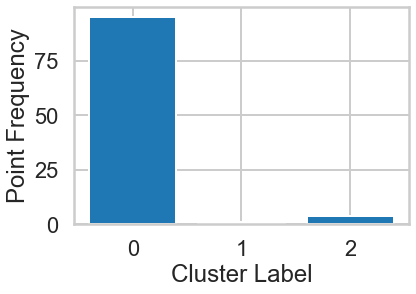

The silhouette average for this classifier: 0.126


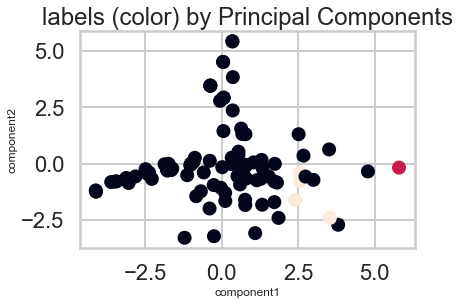

In [15]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=3)
model.fit(x_scld)
labels = model.labels_

#visualize
keys, counts = np.unique(labels, return_counts=True)
plt.bar(keys, counts)
plt.xlabel('Cluster Label')
plt.ylabel('Point Frequency')
plt.show()

#plot 2 principal components and labels classified here
plt.scatter(x=pca_df['x'], y=pca_df['y'], c=labels)
plt.xlabel('component1', fontsize=12)
plt.ylabel('component2', fontsize=12)
plt.title('labels (color) by Principal Components')

#compute silhouette_average for this model
silhouette_avg = silhouette_score(x_cols, labels)
print('The silhouette average for this classifier:', round(silhouette_avg,3))


In [ ]:
%%time

#spectral clustering with parameter tuning
param_space = {
    'n_clusters': list(np.arange(2, 30)),
    'eigen_solver': [None, 'arpack', 'lobpcg'],
    'random_state': 15,
    'n_init': list(np.arange(5, 25, 5)),
    'affinity': ['nearest_neighbors', 'rbf']
}

storage_d = {}
for i in param_space['n_clusters']:
    for solver in param_space['eigen_solver']:
        for n_i in param_space['n_init']:
            for affinity in param_space['affinity']:
                try:
                    spc = SpectralClustering(n_clusters=i,
                                             eigen_solver=solver,
                                             n_init=n_i,
                                             affinity=affinity)

                    labels = spc.fit_predict(x_scld)
                    score = silhouette_score(x_scld, labels)
                    storage_d[score] = str(i) + '|' + str(
                        solver)  + '|' + str(
                            n_i) + '|' + str(affinity)
                    except:
                        next

#identify the best parameters in the range explored by selecting the max value among the keys
a = max(list(storage_d.keys()))

#display the value at that key
print('silhouette_score: ', a, 'parameters:', storage_d[a])

#split and store to rebuild classifier with best parameters
bestparams = storage_d[a].split('|')

#plot 2 principal components and labels classified here
spc = Spectral_clustering(n_clusters=best_params[0],
                          eigen_solver=best_params[1],
                          n_init=best_params[2],
                          affinity=best_params[3])
labels = spc.fit_predict(x_scld)

#plot principal components with best parameter classifier
plt.scatter(x=pca_df['x'], y=pca_df['y'], c=labels)
plt.xlabel('component1', fontsize=12)
plt.ylabel('component2', fontsize=12)
plt.title('labels (color) by Principal Components')

----

#### Agglomerative Clustering

-----

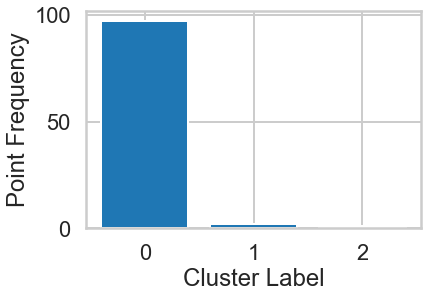

The silhouette average for this classifier: 0.152


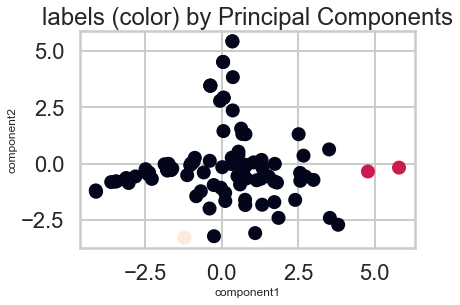

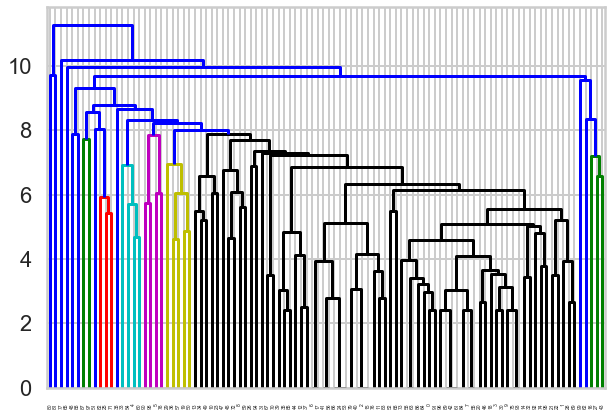

In [50]:
#agglomerative clustering with no parameter tuning
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

model = AgglomerativeClustering(n_clusters=3, linkage='average')
labels = model.fit_predict(x_scld)

#visualize
keys, counts = np.unique(labels, return_counts=True)
plt.bar(keys, counts)
plt.xlabel('Cluster Label')
plt.ylabel('Point Frequency')
plt.show()

#plot 2 principal components and labels classified here
plt.scatter(x=pca_df['x'], y=pca_df['y'], c=labels)
plt.xlabel('component1', fontsize=12)
plt.ylabel('component2', fontsize=12)
plt.title('labels (color) by Principal Components')

#compute silhouette_average for this model
silhouette_avg = silhouette_score(x_cols, labels)
print('The silhouette average for this classifier:', round(silhouette_avg,3))

ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,400., 754., 564., 138., 219., 869., 669.])
Z = hierarchy.linkage(x_scld, 'average')
plt.figure(figsize=(10,7))
dn = hierarchy.dendrogram(Z)

silhouette_score:  0.3333579443491571 parameters: 2|manhattan|single
Wall time: 768 ms


Text(0.5, 1.0, 'labels (color) by Principal Components')

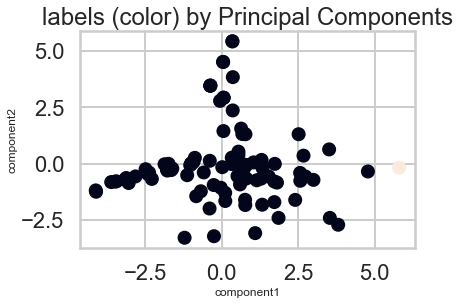

In [18]:
%%time

#agglomerative clustering with parameter tuning
param_space = {
    'n_clusters': list(np.arange(2, 30)),
    'affinity' : ['euclidean','l1','l2','manhattan','cosine'],
    'linkage' : ['ward','complete','average','single'],
}

storage_d = {}
for i in param_space['n_clusters']:
    for affinity in param_space['affinity']:
        for linkage in param_space['linkage']:
            try:
                agc = AgglomerativeClustering(n_clusters=i, affinity=affinity, linkage=linkage, distance_threshold=None)
                labels = agc.fit_predict(x_scld)
                score = silhouette_score(x_scld, labels)
                storage_d[score] = str(i) + '|' +str(
                        affinity) + '|' + str(linkage)
            except:
                next

#identify the best parameters in the range explored by selecting the max value among the keys
a = max(list(storage_d.keys()))

#display the value at that key
print('silhouette_score: ',a, 'parameters:', storage_d[a])

#split and store to rebuild classifier with best parameters
bestparams = storage_d[a].split('|')

#plot 2 principal components and labels classified here
agc = AgglomerativeClustering(n_clusters=int(bestparams[0]), affinity=bestparams[1], linkage=bestparams[2])
labels = agc.fit_predict(x_scld)

#plot principal components with best parameter classifier
plt.scatter(x=pca_df['x'], y=pca_df['y'], c=labels)
plt.xlabel('component1', fontsize=12)
plt.ylabel('component2', fontsize=12)
plt.title('labels (color) by Principal Components')

#### DBSCAN

-----

silhouette score 0.3333579443491571


Text(0.5, 1.0, 'labels (color) by Principal Components')

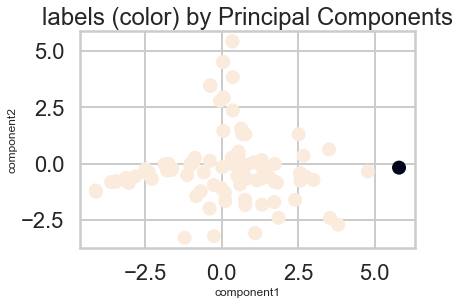

In [19]:
#DBscan with no parameter tuning

from sklearn.cluster import DBSCAN

#fit, classify, and score
dbs = DBSCAN(eps=8)
labels = dbs.fit_predict(x_scld)
score = silhouette_score(x_scld, labels)
print('silhouette score',score)

#plot principal components with best parameter classifier
plt.scatter(x=pca_df['x'], y=pca_df['y'], c=labels)
plt.xlabel('component1', fontsize=12)
plt.ylabel('component2', fontsize=12)
plt.title('labels (color) by Principal Components')

silhouette_score:  0.3333579443491571 parameters: 8.985102040816326|19|auto
Wall time: 6.48 s


Text(0.5, 1.0, 'labels (color) by Principal Components')

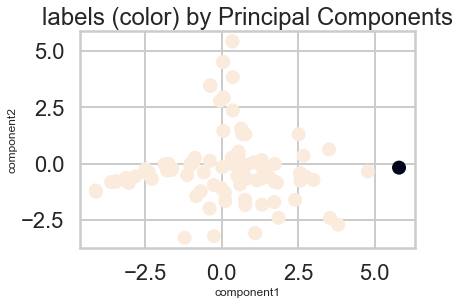

In [20]:
%%time
#DBSCAN with parameter tuning

param_space = {
    'eps': list(np.linspace(0.01, 20, 50)),
    'min_samples': np.arange(2, 20),
    'algorithms': ['ball_tree', 'kd_tree', 'brute', 'auto']
}

storage_d = {}
for i in param_space['eps']:
    for samples in param_space['min_samples']:
        for algorithm in param_space['algorithms']:
            try:
                dbs = DBSCAN(eps=i, min_samples=samples, algorithm=algorithm)
                labels = dbs.fit_predict(x_scld)
                score = silhouette_score(x_scld, labels)
                storage_d[score] =str(i) + '|' + str(
                    samples) + '|' +str(algorithm)
            except:
                next
                
#identify max parameters
a = max(list(storage_d.keys()))  

#display the value at that key
print('silhouette_score: ',a, 'parameters:', storage_d[a])

#split and store to rebuild classifier with best parameters
bestparams = storage_d[a].split('|')

#plot 2 principal components and labels classified here
dbs = DBSCAN(eps=float(bestparams[0]), min_samples=int(bestparams[1]), algorithm=bestparams[2])
labels = dbs.fit_predict(x_scld)

#plot principal components with best parameter classifier
plt.scatter(x=pca_df['x'], y=pca_df['y'], c=labels)
plt.xlabel('component1', fontsize=12)
plt.ylabel('component2', fontsize=12)
plt.title('labels (color) by Principal Components')

### Overall

---

Using the silhouette score to evaluate the classifications, the algorithms without a parameter space to work did arrive at separate solutions. The solution for each when optimized on silhouette_scores was identical across all. Given more resources to devote to this specific problem, I would investigate other evaluation metrics and try to find a solution given weighted consideratons to the parameters that maximized across all of them.

For the initial implementations:
* Affinity Propagation resulted in a model with 17 classes out-of-the-box. That created too many clusters that don't seem to make much sense given the principal component representation of the data.
* Spectral Clustering resulted in a model with 3 classes. Spectral clustering seems to do well when the structure of each individual cluster is highly non-convex. I wouldn't say that this data is highly non-convex but it is certainly not represented by neat, perfect blobs either
* DBSCAN identified two classes which did not help with this data as the data does not present clusters with similar densities
* Agglomerative Clustering resulted in the highest of the silhouette_scores using complete linkage and 3 clusters. However,  note that the trees elongate over the y axis quickly, so even a low cut would result in many classes.

Each model was also tested against parameter ranges for key model parameters and they all identified at a similar solution which, intuitively, is the solution that seems to minimize silhouette score for this data overall. Perhaps writing separate keys for homogeneity, v measure, adjusted rand index, adjusted mutual information, and silhouette scores would be helpful. One could theoretically compute the majority vote parameters across all of those measures and choose those parameter values for a final model. 
